# Problem 4

# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

We will use a pre-trained TTM-1024-96 model. That means the TTM model can take an input of 1024 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.


Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](ibm-granite/granite-timeseries-ttm-r1).

1. TTM-R1 pre-trained models can be found here: [TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
    1. For 512-96 model set `TTM_MODEL_REVISION="main"`
    2. For 1024-96 model set `TTM_MODEL_REVISION="1024_96_v1"`
2. TTM-R2 pre-trained models can be found here: [TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
    1. For 512-96 model set `TTM_MODEL_REVISION="main"`
    2. For 1024-96 model set `TTM_MODEL_REVISION="1024-96-r2"`
    3. For 1536-96 model set `TTM_MODEL_REVISION="1536-96-r2"`

Details about the revisions (R1 and R2) can be found [here](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

## 4.1 Environment Setup - Installation

In [1]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.18"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.18) to /tmp/pip-install-atqsf0yg/tsfm-public_61bee257b11c4b7089ae80fad97c2d82
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-atqsf0yg/tsfm-public_61bee257b11c4b7089ae80fad97c2d82
  Running command git checkout -q 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 4.1 Environment Setup - Imports

In [2]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

2025-11-16 05:44:09.883973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763271850.289908      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763271850.389705      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## 4.1 Environment Setup - Important arguments

In [29]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here etth1) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "ettm2"
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Forecasting parameters
context_length = 1024
forecast_length = 96
fewshot_fraction = 0.05

# ----- TTM model path -----
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"


# ----- TTM model branch -----
# For R2 models
TTM_MODEL_REVISION="1024-96-r2"

## 4.2 Data processing pipeline

**Note:** Here we use the TimeSeriesPreprocessor (TSP) module for data preparation. For standard datasets, TSP can quickly prepare the dataloaders using YAML files defined [here](https://github.com/ibm-granite/granite-tsfm/tree/main/tsfm_public/resources/data_config). Refer to the [TTM Getting Started](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/ttm_getting_started.ipynb) for example usage. Similar YAML file can be written for any new dataset as well.


In [30]:
# Load the data file and see the columns
df = pd.read_csv(DATA_ROOT_PATH)

# View the first 20 rows
print(df.head(20))

                   date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0   2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1   2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2   2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3   2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4   2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
5   2016-07-01 05:00:00  5.626  2.143  1.528  0.533  4.051  1.371  21.174000
6   2016-07-01 06:00:00  7.167  2.947  2.132  0.782  5.026  1.858  22.792000
7   2016-07-01 07:00:00  7.435  3.282  2.310  1.031  5.087  2.224  23.143999
8   2016-07-01 08:00:00  5.559  3.014  2.452  1.173  2.955  1.432  21.667000
9   2016-07-01 09:00:00  4.555  2.545  1.919  0.817  2.680  1.371  17.445999
10  2016-07-01 10:00:00  4.957  2.545  1.990  0.853  2.955  1.492  19.979000
11  2016-07-01 11:00:00  5.760  2.545  2.203  0.853  3.442  1.492  20.118999

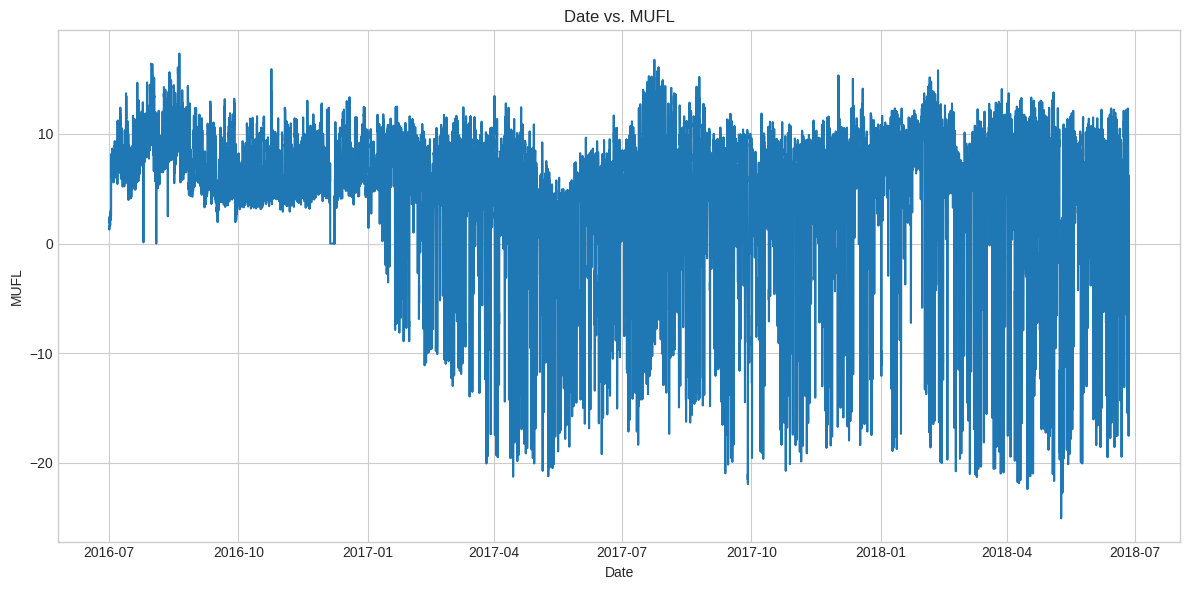

In [31]:
# Plot date vs ”MUFL”
import matplotlib.pyplot as plt
import pandas as pd

df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['MUFL'])
plt.xlabel('Date')
plt.ylabel('MUFL')
plt.title('Date vs. MUFL')
plt.tight_layout()
plt.show()

In [32]:
dataset_path = DATA_ROOT_PATH
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 12 * 30 * 24],
    "valid": [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24],
    "test": [
        12 * 30 * 24 + 4 * 30 * 24,
        12 * 30 * 24 + 8 * 30 * 24,
    ],
}

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Obtain the train_dataset, valid_dataset, test_dataset using tsp get_dataset() by specifying the right arguments
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config
)

# Print the length of train_dataset, valid_dataset, test_dataset
print("Length of train_dataset: " + str(len(train_dataset)))
print("Length of valid_dataset: " + str(len(valid_dataset)))
print("Length of test_dataset: " + str(len(test_dataset)))

Length of train_dataset: 7521
Length of valid_dataset: 2785
Length of test_dataset: 2785


In [33]:
train_dataset[3]

{'past_values': tensor([[-0.4899, -0.0378, -0.6887,  ...,  1.0017,  0.7784,  0.8626],
         [-0.4438, -0.0378, -0.6501,  ...,  1.0613,  0.7784,  0.5252],
         [-0.3977,  0.0584, -0.6436,  ...,  1.2401,  0.9243,  0.4409],
         ...,
         [ 0.8122,  1.3726,  0.6442,  ...,  1.2108,  0.9243,  1.9895],
         [ 0.8468,  1.4683,  0.6056,  ...,  1.3886,  1.0211,  1.8822],
         [ 0.6509,  1.4683,  0.4317,  ...,  1.3886,  1.1163,  1.8132]]),
 'future_values': tensor([[0.7661, 1.3726, 0.5411, 1.1990, 1.5078, 0.7784, 1.6139],
         [1.7342, 0.9880, 1.1914, 0.5351, 3.5312, 0.9719, 1.5755],
         [1.6996, 0.7315, 1.1079, 0.0554, 3.4130, 1.0687, 1.5525],
         [2.3218, 2.3659, 1.9126, 1.9185, 2.7877, 0.8275, 1.5678],
         [2.0567, 1.8209, 1.7388, 1.2914, 2.2220, 0.8275, 1.5372],
         [2.2412, 1.8851, 1.7388, 1.2359, 3.7100, 1.4067, 1.5678],
         [2.2066, 2.1736, 1.6551, 1.1990, 3.5019, 1.3591, 1.4835],
         [1.7687, 1.2765, 1.3139, 0.7562, 3.0261, 1.2131,

## 4.3 Zero-shot evaluation method

In [34]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)
zeroshot_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=128, out_features=384, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
             

In [36]:
#Perform zero-shot evaluation using the pre-trained model on the test dataset and calculate the evaluation error.
import wandb

# Login to wandb and initialize it
wandb.login(key = "43d56b51a7a89074cdecf6fd4ef49d1d5256762e")
wandb.init(project="hw4_problem4", name="zero_shot_eval_1")

temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        seed=SEED,
    ),
)

zeroshot_results = zeroshot_trainer.evaluate(test_dataset)
print("Evaluation Loss: " + str(zeroshot_results["eval_loss"]))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Loss: 0.35860303044319153


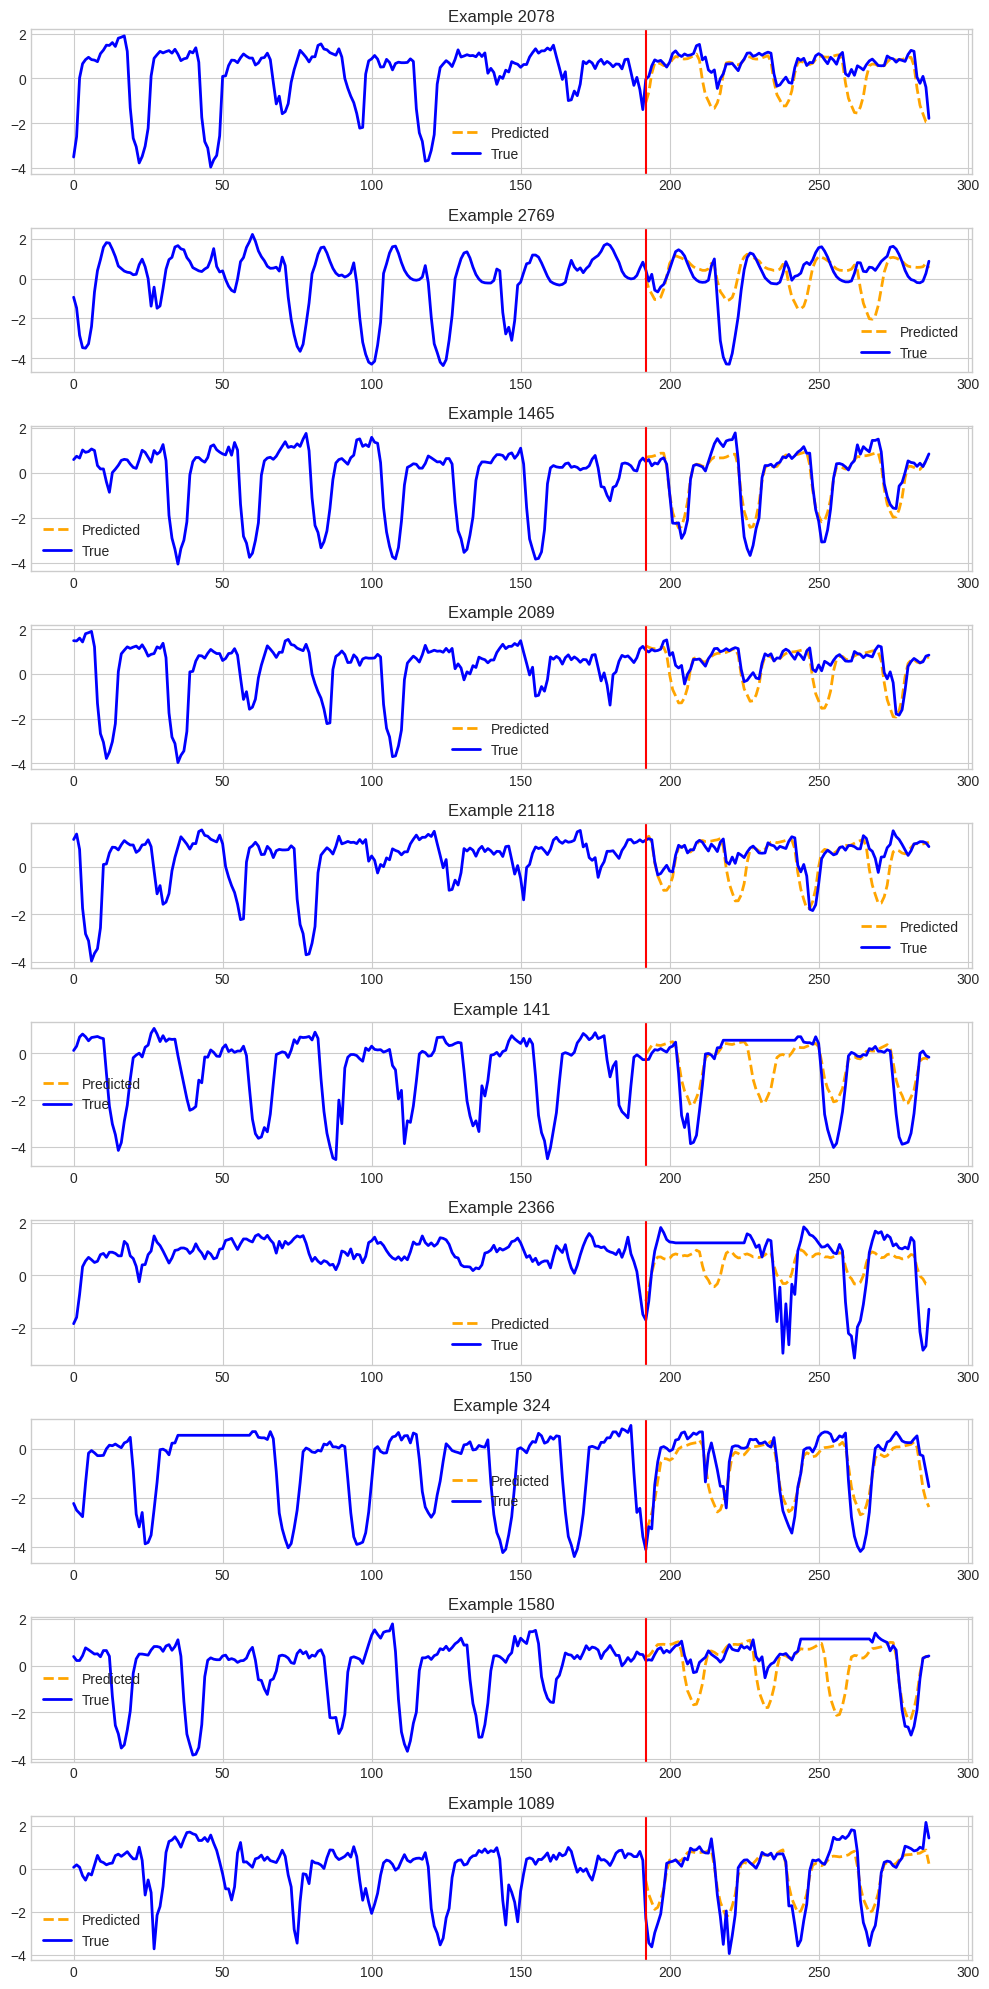

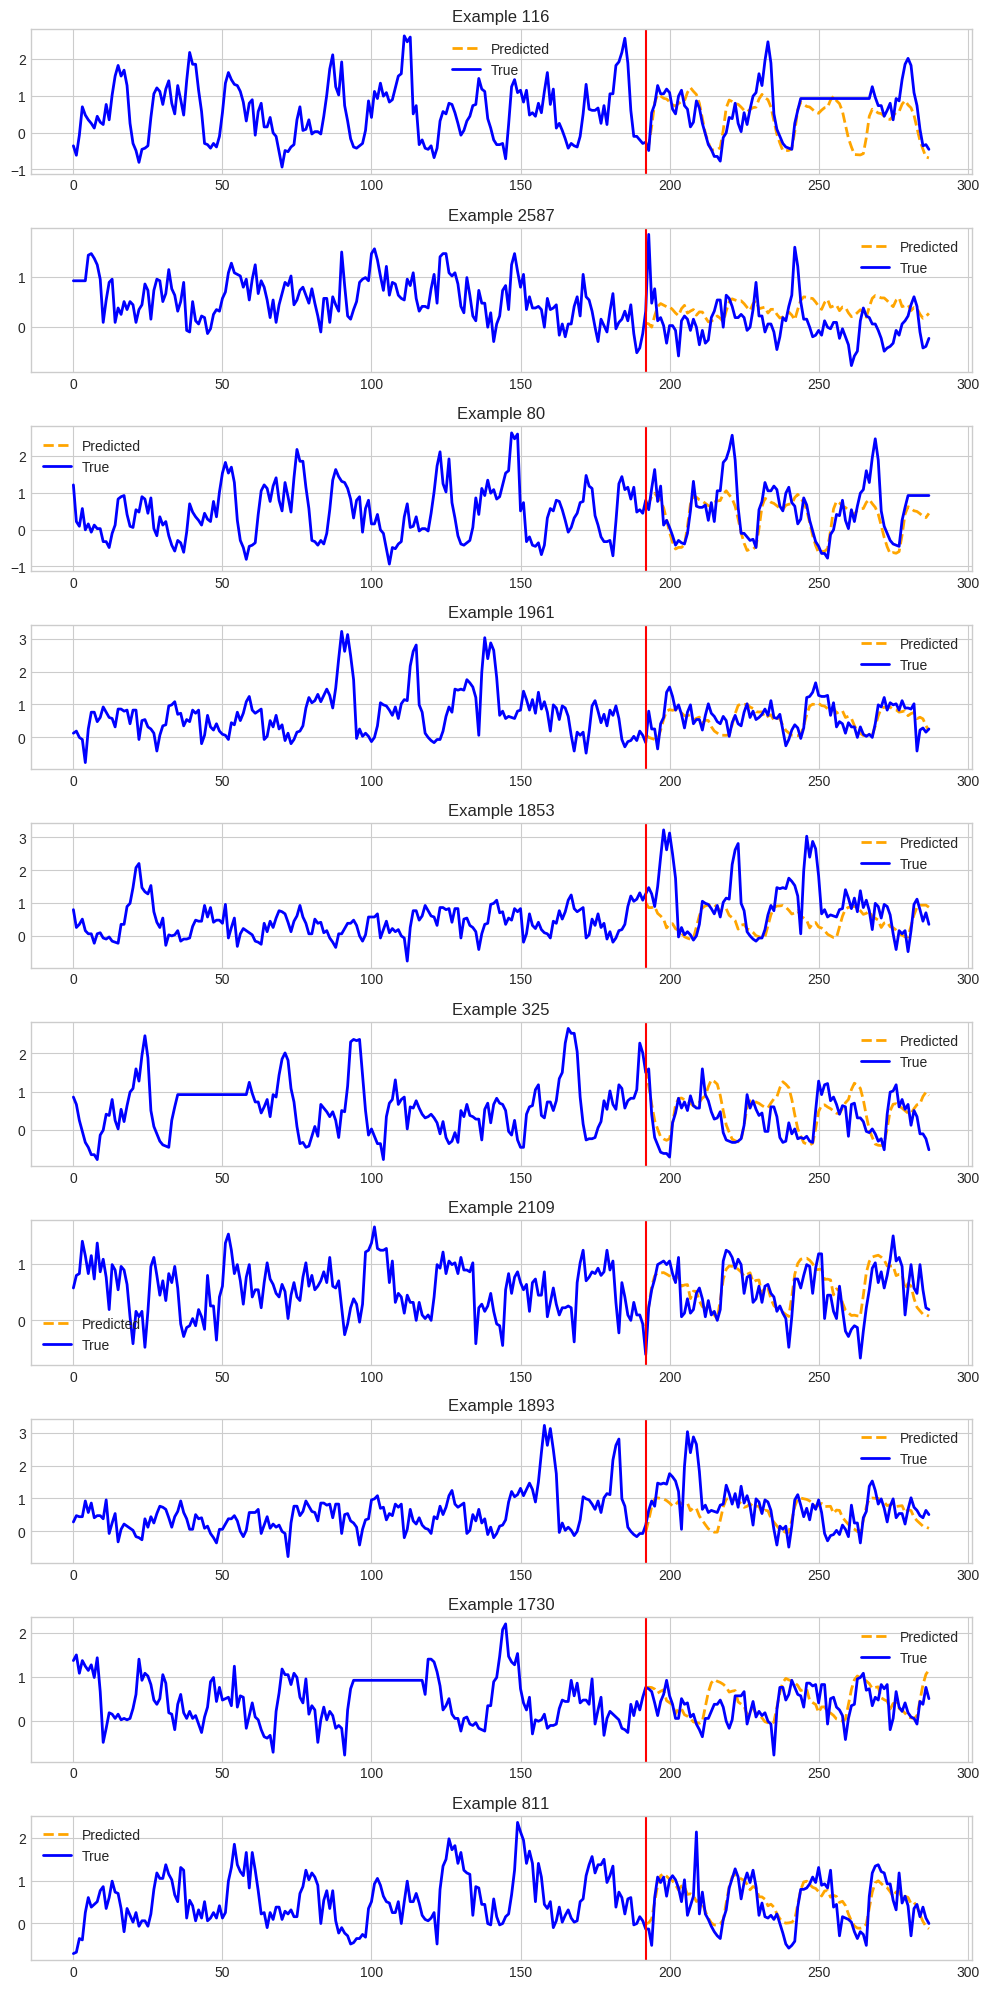

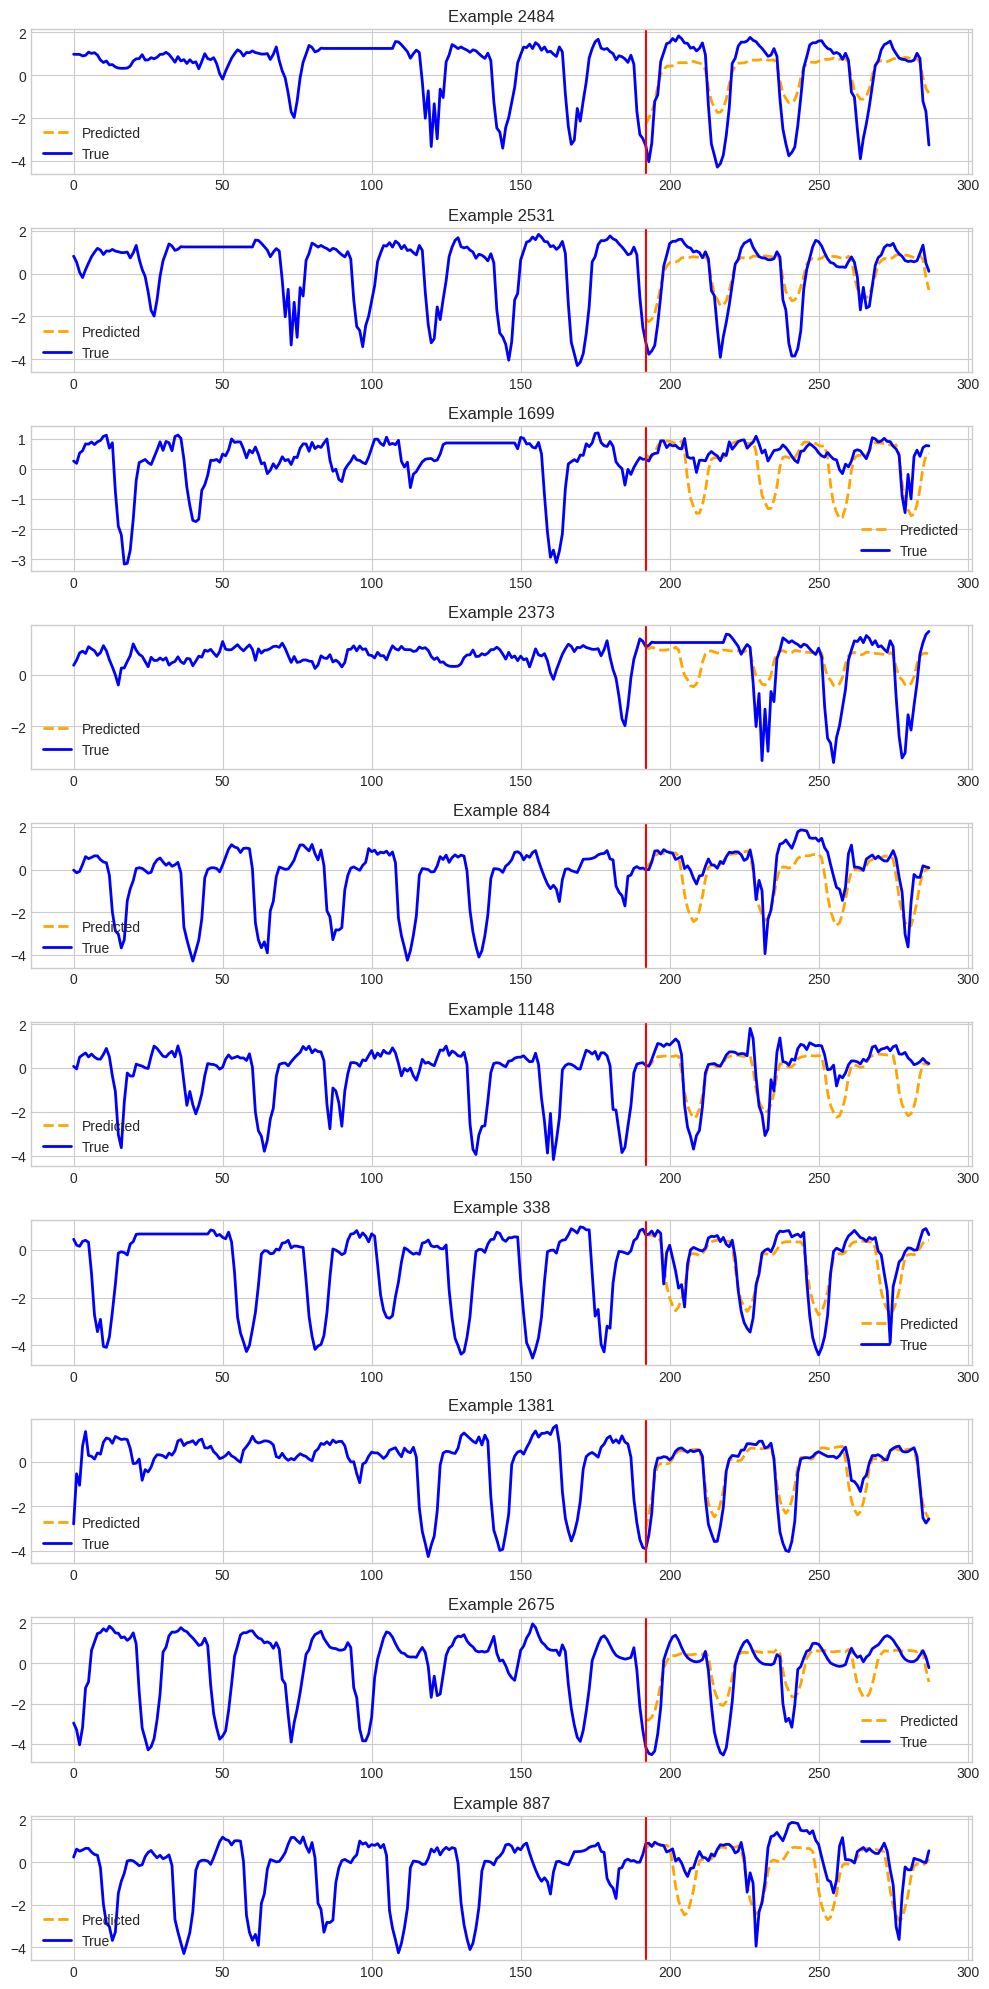

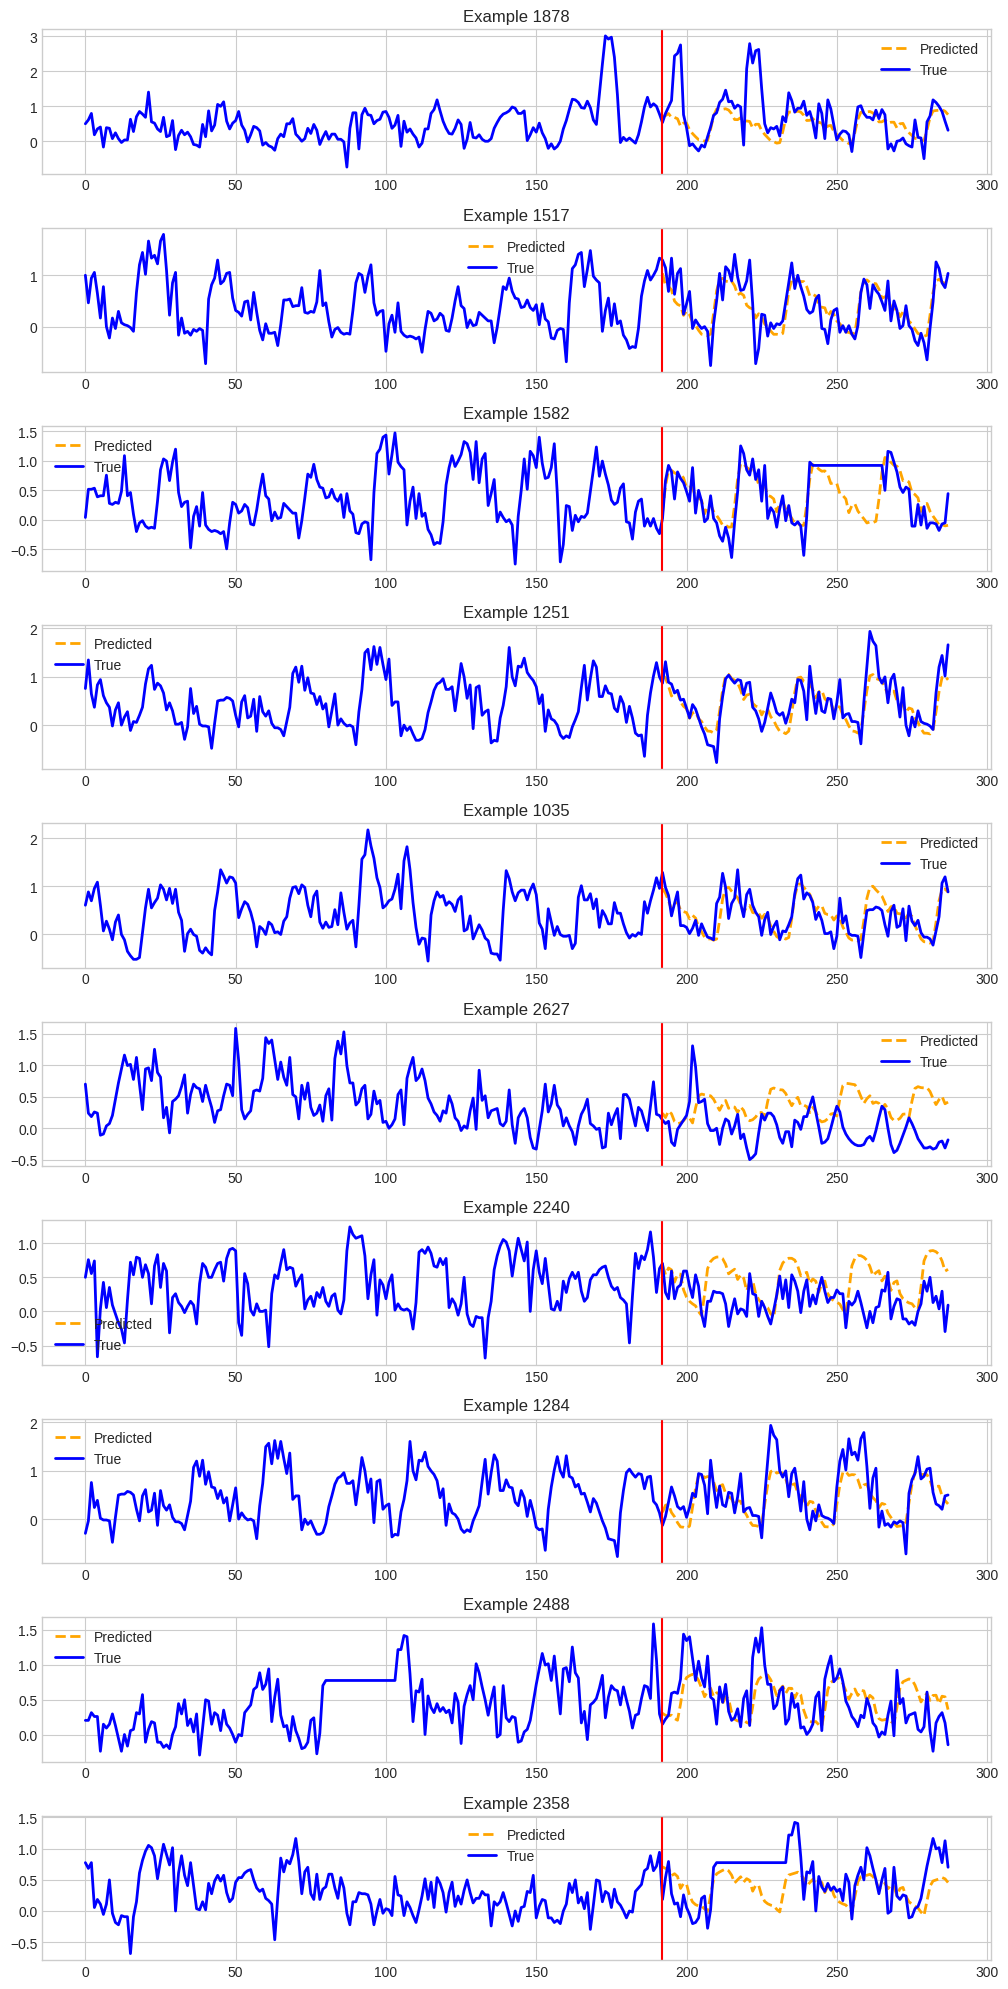

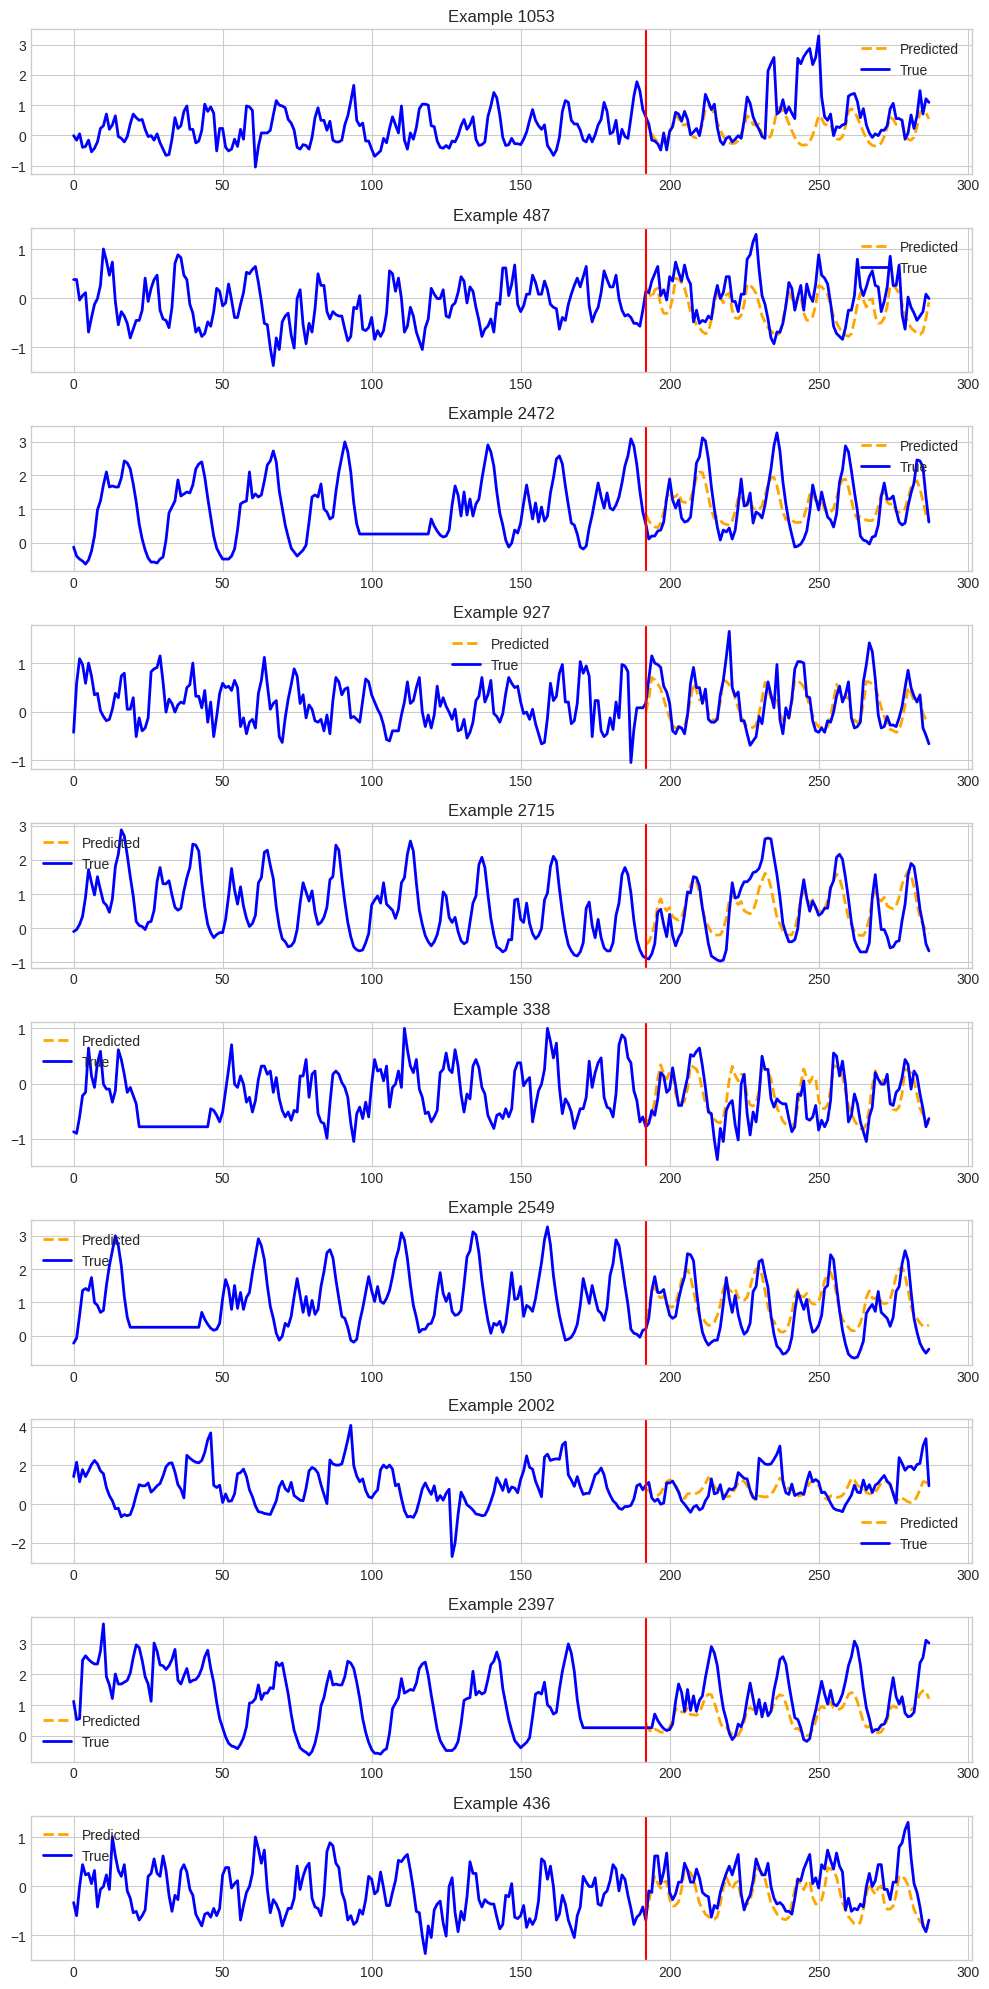

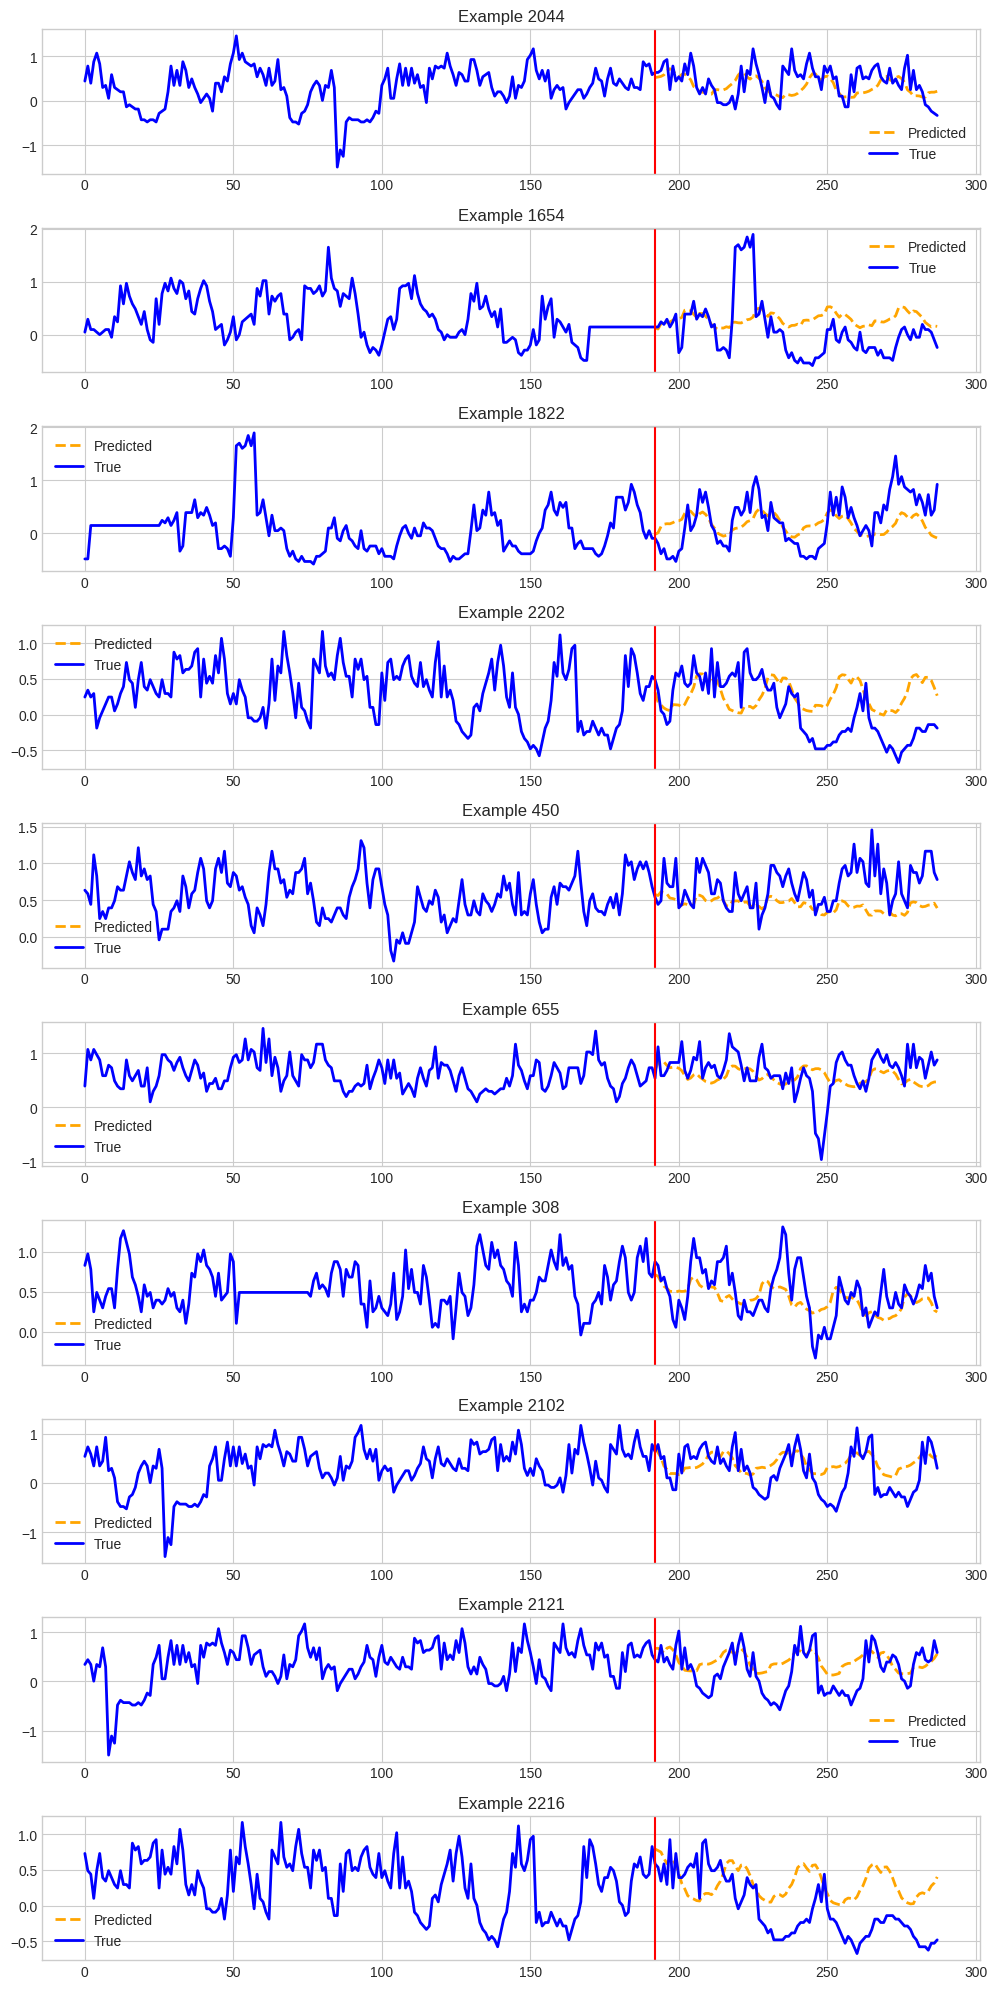

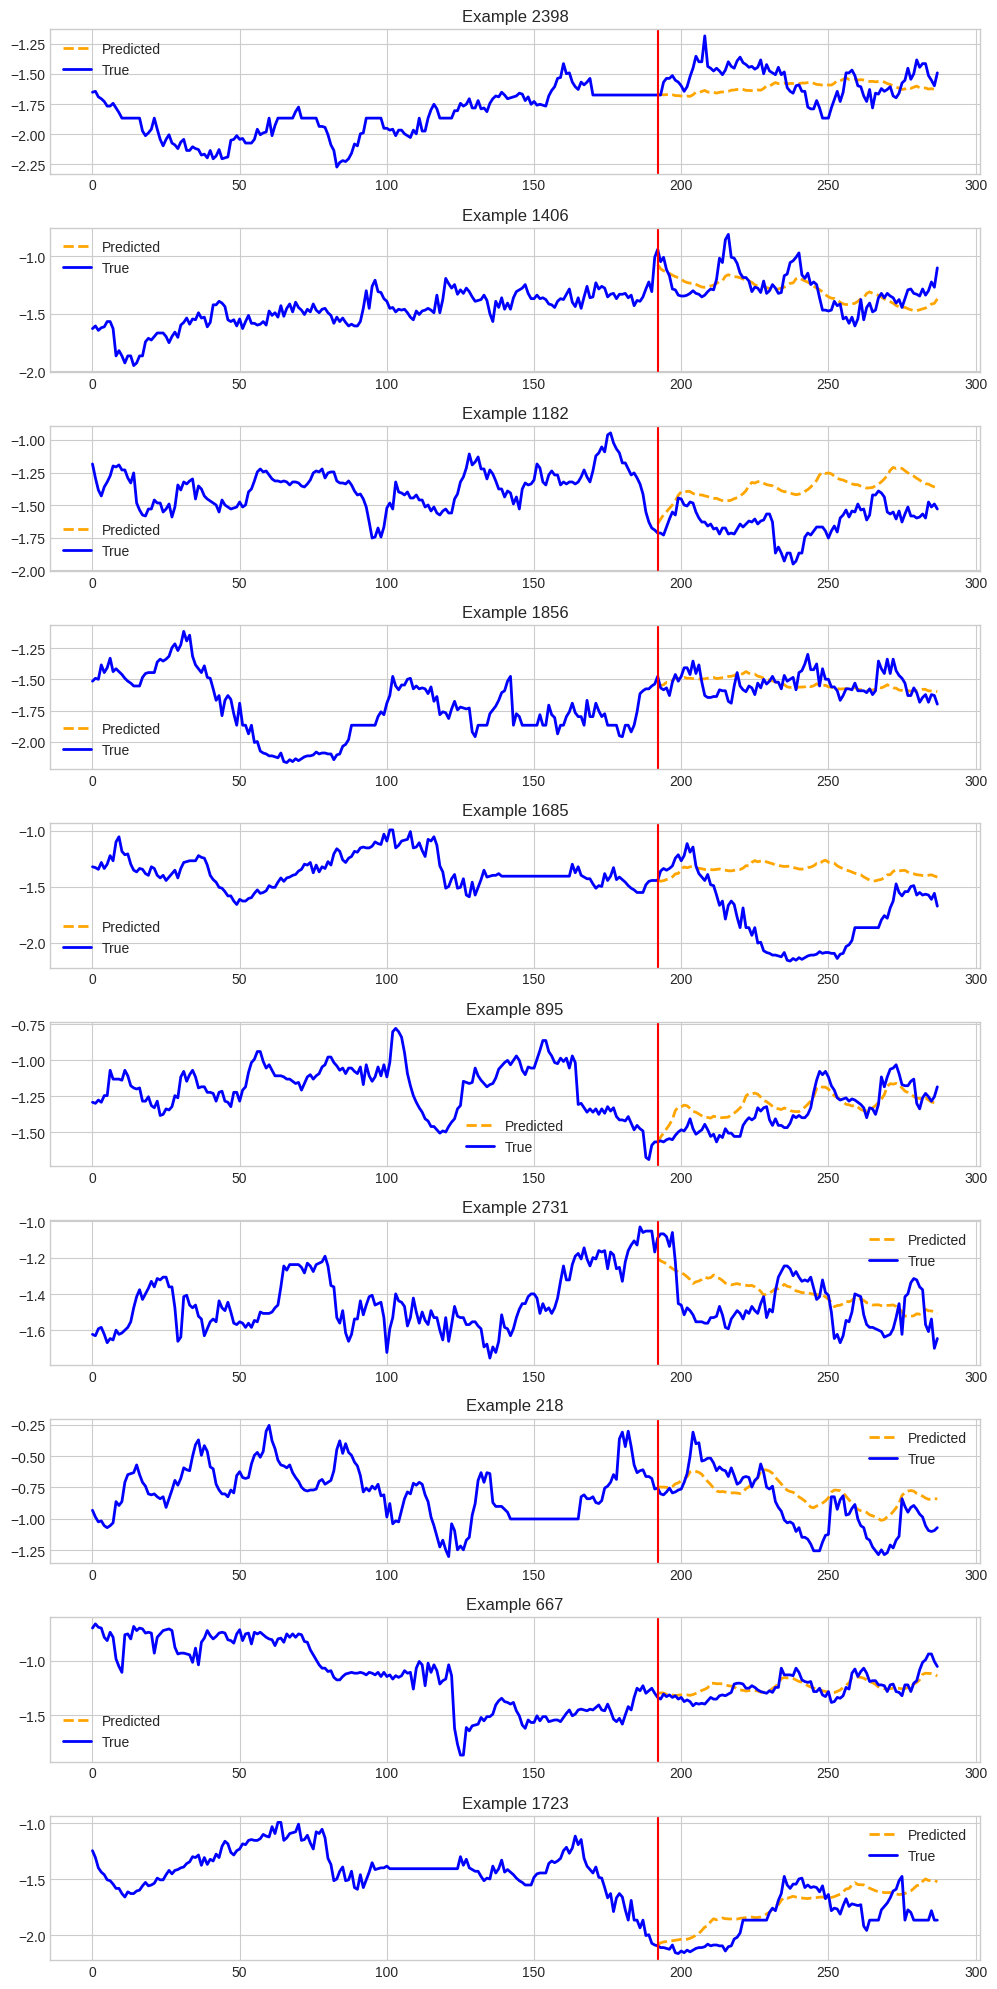

In [37]:
# # plot the zero-shot predictions
# The following code plots predictions for 10 samples for every target column
# target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
# 70 plots in total

for i, col in enumerate(target_columns):
    plot_predictions(
        model=zeroshot_model,
        dset=test_dataset,
        plot_dir=OUT_DIR,
        plot_prefix="test_zeroshot",
        channel=i
    )

## 4.4 Zero-shot evaluation by truncating the length

In [38]:
#Forecast 24 hrs in the future using the TTM-1024-96 model

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=24,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config
)

zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH, 
    revision=TTM_MODEL_REVISION,
    prediction_filter_length=24  
)

temp_dir = tempfile.mkdtemp()
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        seed=SEED,
    ),
)

wandb.init(project="hw4_problem4", name="zero_shot_eval_2")

zeroshot_results = zeroshot_trainer.evaluate(test_dataset)
print("Evaluation Loss: " + str(zeroshot_results["eval_loss"]))

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/global_step,▁
eval/loss,0.3586
eval/runtime,1.4864
eval/samples_per_second,1873.666
eval/steps_per_second,14.801
train/global_step,0


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Loss: 0.3100925385951996


 ## 4.5 Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [39]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, head_dropout=0.7
)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=128, out_features=384, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
             

### Freeze the TTM backbone

In [40]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for name, param in finetune_forecast_model.named_parameters():
    if "head" not in name:
        param.requires_grad = False


# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 2964960
Number of params after freezing the backbone 196704


### Finetune few-shot 5%

In [41]:
# Important parameters
learning_rate = 0.001
num_epochs = 1  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

In [48]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    seed=SEED,
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config
)

def create_few_shot_dataset(dataset, percentage):
    import torch
    total_samples = len(dataset)
    num_samples = int(total_samples * percentage)
    indices = list(range(num_samples))
    return torch.utils.data.Subset(dataset, indices)

train_dataset_5 = create_few_shot_dataset(train_dataset, 0.05)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset_5,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.559500,0.675480


[TrackingCallback] Mean Epoch Time = 0.6967084407806396 seconds, Total Train Time = 2.377359390258789


TrainOutput(global_step=3, training_loss=0.5594596068064371, metrics={'train_runtime': 2.415, 'train_samples_per_second': 155.693, 'train_steps_per_second': 1.242, 'total_flos': 47946391879680.0, 'train_loss': 0.5594596068064371, 'epoch': 1.0})

In [49]:
# Evaluate the fine-tuned model
finetune_forecast_model_results = finetune_forecast_trainer.evaluate(test_dataset)
print("Evaluation Loss: " + str(finetune_forecast_model_results["eval_loss"]))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Loss: 0.3596187233924866


### Finetune few-shot 10%

In [50]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config
)

def create_few_shot_dataset(dataset, percentage):
    import torch
    total_samples = len(dataset)
    num_samples = int(total_samples * percentage)
    indices = list(range(num_samples))
    return torch.utils.data.Subset(dataset, indices)

train_dataset_10 = create_few_shot_dataset(train_dataset, 0.10)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset_10,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.507200,0.675216


[TrackingCallback] Mean Epoch Time = 0.8784408569335938 seconds, Total Train Time = 2.6249022483825684


TrainOutput(global_step=6, training_loss=0.5072402954101562, metrics={'train_runtime': 2.6367, 'train_samples_per_second': 285.208, 'train_steps_per_second': 2.276, 'total_flos': 95892783759360.0, 'train_loss': 0.5072402954101562, 'epoch': 1.0})

In [51]:
# Evaluate the fine-tuned model
finetune_forecast_model_results = finetune_forecast_trainer.evaluate(test_dataset)
print("Evaluation Loss: " + str(finetune_forecast_model_results["eval_loss"]))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Loss: 0.3602588474750519


## 4.6 Few-shot evaluation by changing loss function
Try few-shot 5% forecasting on etth1 by changing the `loss` to `mae` (mean absolute error). Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

In [52]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config
)

def create_few_shot_dataset(dataset, percentage):
    import torch
    total_samples = len(dataset)
    num_samples = int(total_samples * percentage)
    indices = list(range(num_samples))
    return torch.utils.data.Subset(dataset, indices)

train_dataset_5 = create_few_shot_dataset(train_dataset, 0.05)

finetune_forecast_model_mae = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH,
    revision=TTM_MODEL_REVISION,
    loss="mae"  # Change loss to MAE
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model_mae,
    args=finetune_forecast_args,
    train_dataset=train_dataset_5,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.434600,0.556280


[TrackingCallback] Mean Epoch Time = 0.8676722049713135 seconds, Total Train Time = 2.599323272705078


TrainOutput(global_step=3, training_loss=0.43460126717885333, metrics={'train_runtime': 2.6116, 'train_samples_per_second': 143.973, 'train_steps_per_second': 1.149, 'total_flos': 47946391879680.0, 'train_loss': 0.43460126717885333, 'epoch': 1.0})

In [53]:
# Evaluate the fine-tuned model
finetune_forecast_model_results = finetune_forecast_trainer.evaluate(test_dataset)
print("Evaluation Loss: " + str(finetune_forecast_model_results["eval_loss"]))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Loss: 0.39422306418418884


## 4.7 Zero-shot on channel 0 and 2
In your notebook, add `prediction_channel_indices=[0,2]` during model loading to forecast only 0th and 2nd channels. In this case, execute the following code and note the output shape.
```
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, prediction_channel_indices=[0,2])
output = zeroshot_model.forward(test_dataset[0]['past_values'].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape
```

In [54]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, prediction_channel_indices=[0,2])
output = zeroshot_model.forward(test_dataset[0]['past_values'].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape

torch.Size([1, 96, 2])